In [32]:
import os
import logging
import requests
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import random
import time # Included for standard scraping practice, although not used in the logic provided

# --- Configuration ---
# NOTE: You MUST have chromedriver.exe located at this path, or update the path.
CHROME_DRIVER_PATH = 'chromedriver.exe' 
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
url = 'https://en.wikipedia.org/wiki/List_of_largest_banks_in_Africa'

# Dummy list for user agent, replace with your actual list or install a library for it
USER_AGENTS = [
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36',
]

In [33]:
def parse_bank_data(html_content):
    """Parses the HTML content to extract data from the first 'wikitable'."""
    soup = BeautifulSoup(html_content, 'html.parser')
    table = soup.find('table', {'class': 'wikitable'})
    
    if not table:
        logger.error("Could not find the bank data table (wikitable) on the page.")
        return "Table not found", pd.DataFrame() 

    # Extract headers (th)
    headers = [header.text.strip() for header in table.find_all('th')]
    
    # Extract rows (tr), skipping the first row [1:]
    rows = []
    for row in table.find_all('tr')[1:]:
        cols = row.find_all(['td', 'th'])
        cols = [col.text.strip() for col in cols]
        
        if cols:
            rows.append(cols)

    df = pd.DataFrame(rows, columns=headers)
    return None, df

def fetch_page_content(url):
    """Fetches the HTML content using requests and handles initial status checks."""
    try:
        response = requests.get(url)
        
        if response.status_code == 403:
            logger.info("Access forbidden (403). Falling back to Selenium.")
            return "Fallback needed", response.text
        
        response.raise_for_status() # Raise HTTPError for other bad responses (4xx or 5xx)

        # Success case (HTTP 200)
        logger.info("Successfully fetched content via requests.")
        return None, response.text
        
    except requests.exceptions.HTTPError as e:
        logger.error(f"HTTP Error fetching content: {e}. Falling back...")
        return f"HTTP Error: {e}", "" # Return empty content on severe HTTP error
        
    except requests.exceptions.RequestException as e:
        logger.error(f"Network Error fetching page content: {e}")
        return str(e), ""

def selenium_fallback(url, driver):
    """Uses the initialized Selenium driver if requests failed or encountered a 403."""
    
    error, content = fetch_page_content(url)
    
    if error is None:
        # Requests succeeded (HTTP 200), parse the content directly
        logger.info("Parsing content fetched via requests.")
        return parse_bank_data(content)
        
    elif error == "Fallback needed":
        # Requests failed (e.g., 403), use Selenium
        logger.info("Using Selenium to fetch the page content.")
        try:
            driver.get(url)
            html_content = driver.page_source
            logger.info("Parsing content fetched via Selenium.")
            return parse_bank_data(html_content)
            
        except Exception as e:
            logger.error(f"Selenium execution failed: {e}")
            return str(e), pd.DataFrame()
    
    else:
        # Other requests error occurred (e.g., 404, network error)
        logger.error(f"Terminal error occurred: {error}")
        return error, pd.DataFrame()

def run_scraper(driver_path=CHROME_DRIVER_PATH, headless=True):
    """Initializes the driver and runs the scraping logic with cleanup."""
    
    if not os.path.exists(driver_path):
        logger.error(f"ChromeDriver not found at path: {driver_path}.")
        return "Driver not found", pd.DataFrame()

    chrome_options = Options()
    if headless:
        chrome_options.add_argument('--headless=new') 
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument(f'user-agent={random.choice(USER_AGENTS)}')
    
    driver = None
    try:
        # Initialize WebDriver
        driver = webdriver.Chrome(service=Service(driver_path), options=chrome_options)
        driver.set_page_load_timeout(30)
        
        # Run the core scraping logic
        error, df = selenium_fallback(url, driver)
        return error, df

    except Exception as e:
        logger.error(f"A critical error occurred during driver setup or execution: {e}")
        return str(e), pd.DataFrame()
        
    finally:
        # Always quit the driver if it was successfully initialized
        if driver:
            driver.quit() 
            logger.info("ChromeDriver closed.")

In [34]:
from IPython.display import display

In [51]:
# --- Main Execution Block ---

logger.info("Starting main scraping process...")

# Call the top-level function
error, df = run_scraper()

if error is None:
    print("\n--- SCRAPING SUCCESS ---")
    print(f"Collected {len(df)} records.")
    
    # NEW LINE: Explicitly display the DataFrame using the display function
    display(df) 
    
    # You can also display the full DataFrame if you prefer:
    # display(df)
    
    # Add your code here to save the df (e.g., df.to_csv('banks.csv'))
else:
    print(f"\n--- SCRAPING FAILED ---")
    print(f"Error: {error}")
    print("No records were collected.")

2025-11-25 15:40:17,683 - INFO - Starting main scraping process...
2025-11-25 15:40:20,936 - INFO - Access forbidden (403). Falling back to Selenium.
2025-11-25 15:40:20,954 - INFO - Using Selenium to fetch the page content.
2025-11-25 15:40:24,028 - INFO - Parsing content fetched via Selenium.
2025-11-25 15:40:26,388 - INFO - ChromeDriver closed.



--- SCRAPING SUCCESS ---
Collected 50 records.


,Rank,Bank name,hideTotal assets(2024)(US$ Millions)
0,1,Standard Bank Group,167 000
1,2,National Bank of Egypt,155 000
2,3,Banque Misr,104 000
3,4,FirstRand,88 000
4,5,Absa Bank,83 000
5,6,Attijariwafa Bank,67 000
6,7,Nedbank,67 000
7,8,Banque Populaire,53 000
8,9,Banque Nationale d'Algérie [fr],41 000
9,10,Bank of Africa,39 000


In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
asset_col = 'hideTotal assets(2024)(US$ Millions)' # Use your verified column name!
print("--- Raw Data Sample ---")
print(df[asset_col].head(10))

--- Raw Data Sample ---
0    167 000
1    155 000
2    104 000
3     88 000
4     83 000
5     67 000
6     67 000
7     53 000
8     41 000
9     39 000
Name: hideTotal assets(2024)(US$ Millions), dtype: object


In [45]:
asset_col = 'hideTotal assets(2024)(US$ Millions)' # Use your verified column name!
print(df[asset_col].astype(str).head(10))

0    167 000
1    155 000
2    104 000
3     88 000
4     83 000
5     67 000
6     67 000
7     53 000
8     41 000
9     39 000
Name: hideTotal assets(2024)(US$ Millions), dtype: object


In [53]:
asset_col = 'hideTotal assets(2024)(US$ Millions)' 
clean_asset_col = 'Assets_Numeric' 

# 1. PRE-CLEANING: Handle known non-visible characters first
# If the diagnosis showed ASCII 160, use:
df[clean_asset_col] = df[asset_col].astype(str).str.replace(chr(160), '', regex=False)
# Also replace any newlines/tabs
df[clean_asset_col] = df[clean_asset_col].str.replace(r'[\n\t\r]', '', regex=True)


# 2. CORE CLEANING: Remove commas and noise
# Explicitly remove the thousands separator (comma)
df[clean_asset_col] = df[clean_asset_col].str.replace(',', '', regex=False)

# Remove footnotes and currency symbols
df[clean_asset_col] = df[clean_asset_col].str.replace(r'[$,\[].*?$', '', regex=True).str.strip()


# 3. EXTRACTION & CONVERSION: Safely convert to numeric
# Extract the first valid number pattern (digits and decimal)
df[clean_asset_col] = df[clean_asset_col].str.extract(r'(\d+\.?\d*)', expand=False)
df[clean_asset_col] = pd.to_numeric(df[clean_asset_col], errors='coerce') 

# --- Verification ---
valid_count = df[clean_asset_col].count()
print(f"Successfully converted {valid_count} numbers to numeric.")

Successfully converted 50 numbers to numeric.


In [54]:
display(df[['Bank name', asset_col, clean_asset_col]].head(10))

,Bank name,hideTotal assets(2024)(US$ Millions),Assets_Numeric
0,Standard Bank Group,167 000,167
1,National Bank of Egypt,155 000,155
2,Banque Misr,104 000,104
3,FirstRand,88 000,88
4,Absa Bank,83 000,83
5,Attijariwafa Bank,67 000,67
6,Nedbank,67 000,67
7,Banque Populaire,53 000,53
8,Banque Nationale d'Algérie [fr],41 000,41
9,Bank of Africa,39 000,39


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10108\565949007.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


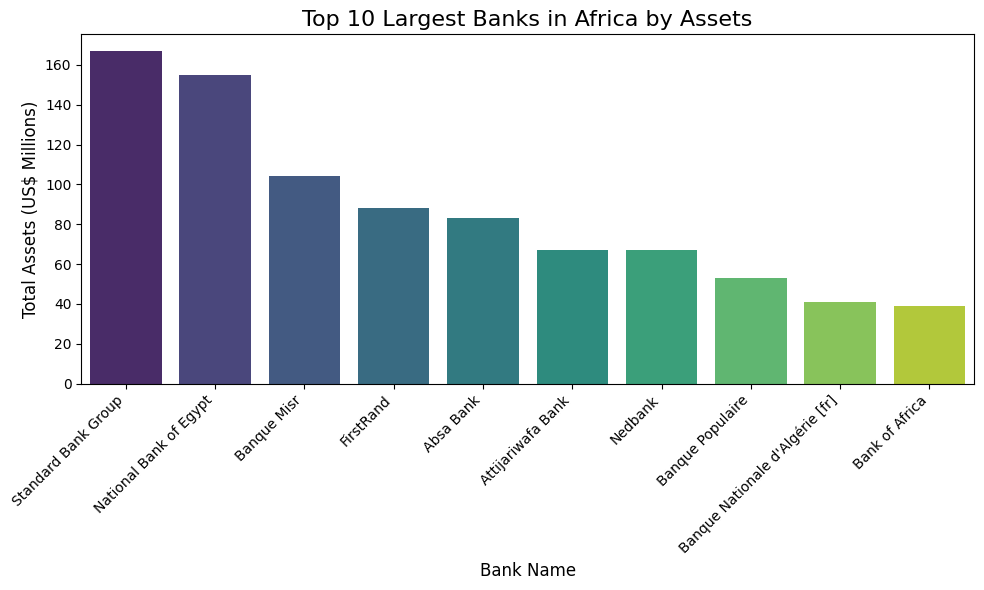

In [56]:
# Use the new, clean column for sorting and plotting
clean_asset_col = 'Assets_Numeric' 
bank_col = 'Bank name' 

# Sort and get top 10, dropping rows that couldn't be cleaned (NaNs)
df_sorted = df.dropna(subset=[clean_asset_col]).sort_values(by=clean_asset_col, ascending=False).head(10)

if len(df_sorted) > 0:
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=bank_col, 
        y=clean_asset_col,
        data=df_sorted, 
        palette='viridis' 
    )
    plt.title('Top 10 Largest Banks in Africa by Assets', fontsize=16)
    plt.xlabel('Bank Name', fontsize=12)
    plt.ylabel('Total Assets (US$ Millions)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Cannot plot: DataFrame is still empty after cleaning. Re-check the column name in step 1.")